In [1]:
using DelimitedFiles, HDF5, FileIO
using Plots, Rsvg, LaTeXStrings, StatsPlots
using Chemfiles, JUMD
using LinearAlgebra, Statistics
home = "/home/pbarletta/labo/18/lbp/run"
rtdos = "/home/pbarletta/labo/18/lbp/rtdos_log"
pyplot()

Plots.PyPlotBackend()

### Lee modos, volumen original y  volúmenes NDD. Obtiene VGV

In [6]:
pdb = "4xcp"
# Leo modos
modes_4xcp, evals_4xcp = JUMD.readPtrajModes(
    joinpath(home, pdb,  "pca", string("modes_", pdb)))

# AAs
aa3 = convert(Int64, length(evals_4xcp))
aa = convert(Int64, aa3 / 3)

# Leo volumen de la traj
trj_vol = convert(Array{Float64, 1}, 
    readdlm(joinpath(home, pdb, "cavidad", string("vol_trj_", pdb)))[:, 3]);

# Leo volúmene del average
vol_avg_4xcp = convert(Float64, readdlm(joinpath(home, pdb,  "ndd", string("vol_avg_", pdb)))[3])

# Leo volúmenes NDD
ndd_out_4xcp = convert(Array{Float64, 1},
    readdlm(joinpath(home, pdb,  "ndd", string("out_ndd_", pdb)))[2:end, 2])

# VGV
vgv_4xcp = (ndd_out_4xcp .- vol_avg_4xcp) .* evals_4xcp
vgv_4xcp = vgv_4xcp ./ norm(vgv_4xcp);

### Obtengo proyecciones de PCA sobre trayectoria

In [7]:
dif = h5read(joinpath(rtdos, string("diff_", pdb, ".h5")), "dif")
norm_dif = mapslices(x -> x ./ norm(x), dif,  dims = 1)
nframes = size(dif)[2]

prj_1_4xcp = Array{Float64, 1}(undef, nframes)
prj_2_4xcp = Array{Float64, 1}(undef, nframes)
prj_3_4xcp = Array{Float64, 1}(undef, nframes)

for i = 1:nframes
    prj_1_4xcp[i] = dot(norm_dif[:, i], modes_4xcp[:, 1])
    prj_2_4xcp[i] = dot(norm_dif[:, i], modes_4xcp[:, 2])
    prj_3_4xcp[i] = dot(norm_dif[:, i], modes_4xcp[:, 3])
end

# Smooth
smooth_prj_1_4xcp = [ mean(prj_1_4xcp[i:i+9]) for i = 1:10:length(prj_1_4xcp)-9 ]
smooth_prj_2_4xcp = [ mean(prj_2_4xcp[i:i+9]) for i = 1:10:length(prj_2_4xcp)-9 ]
smooth_prj_3_4xcp = [ mean(prj_3_4xcp[i:i+9]) for i = 1:10:length(prj_3_4xcp)-9 ];

# Energía de poblaciones

In [8]:
# Leo modos
modes_1, evals_1 = JUMD.readPtrajModes(joinpath(home, pdb, "poblaciones",
        "pca", "1", string("1", "vol_modes_", pdb)))
modes_2, evals_2 = JUMD.readPtrajModes(joinpath(home, pdb, "poblaciones",
        "pca", "2", string("2", "vol_modes_", pdb)))
modes_3, evals_3 = JUMD.readPtrajModes(joinpath(home, pdb, "poblaciones",
        "pca", "3", string("3", "vol_modes_", pdb)))

# Leo volúmenes originales
vol_avg_1 = convert(Float64, readdlm(joinpath(home, pdb, "poblaciones",
            "ndd", "1", string("vol_avg_", pdb)))[3])
vol_avg_2 = convert(Float64, readdlm(joinpath(home, pdb, "poblaciones",
            "ndd", "2", string("vol_avg_", pdb)))[3])
vol_avg_3 = convert(Float64, readdlm(joinpath(home, pdb, "poblaciones",
            "ndd", "3", string("vol_avg_", pdb)))[3])

# Leo volúmenes NDD
ndd_out_1 = convert(Array{Float64, 1},
    readdlm(joinpath(home, pdb, "poblaciones", "ndd", "1", string("out_ndd_", pdb)))[2:end, 2])
# VGV
vgv_1 = (ndd_out_1 .- vol_avg_1) .* evals_1
vgv_1 = vgv_1 ./ norm(vgv_1);

# Leo volúmenes NDD
ndd_out_2 = convert(Array{Float64, 1},
    readdlm(joinpath(home, pdb, "poblaciones", "ndd", "2", string("out_ndd_", pdb)))[2:end, 2])
# VGV
vgv_2 = (ndd_out_2 .- vol_avg_2) .* evals_2
vgv_2 = vgv_2 ./ norm(vgv_2);

# Leo volúmenes NDD
ndd_out_3 = convert(Array{Float64, 1},
    readdlm(joinpath(home, pdb, "poblaciones", "ndd", "3", string("out_ndd_", pdb)))[2:end, 2])
# VGV
vgv_3 = (ndd_out_3 .- vol_avg_3) .* evals_3
vgv_3 = vgv_3 ./ norm(vgv_3);

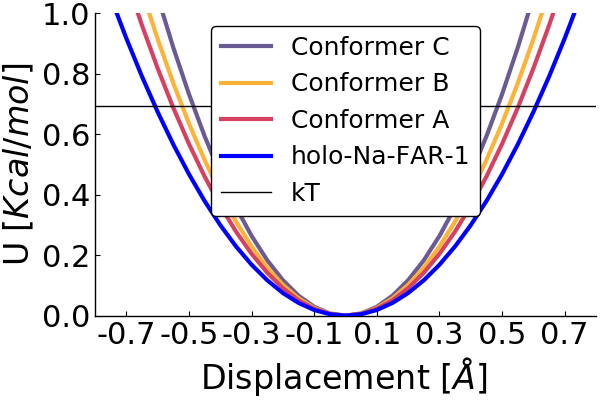

In [22]:
pasos = collect(-.8:.05:.8)
npasos = length(pasos)
RT = 0.693

E_4xcp = Array{Float64,1}(undef, npasos)
[ E_4xcp[i] = JUMD.energiaGdte(evals_4xcp, vgv_4xcp, pasos[i]) for i in 1:npasos]

E_1 = Array{Float64, 1}(undef, npasos)
[ E_1[i] = JUMD.energiaGdte(evals_1, vgv_1, pasos[i]) for i in 1:npasos]

E_2 = Array{Float64, 1}(undef, npasos)
[ E_2[i] = JUMD.energiaGdte(evals_2, vgv_2, pasos[i]) for i in 1:npasos]

E_3 = Array{Float64, 1}(undef, npasos)
[ E_3[i] = JUMD.energiaGdte(evals_3, vgv_3, pasos[i]) for i in 1:npasos];

plt_u = plot(pasos, E_3, lab = "Conformer C",
    xticks = -.7:.2:.7, yticks = 0:.2:1.,   
    xlims = (-.8, .8),
    ylims = (0, 1.),
    yaxis = L"U $[Kcal/mol]$", xaxis = L"Displacement $[\AA]$ ",
    linecolor = Colors.colorant"#6b5b95", linewidth = 3,
    grid = false,
    
#     legend = false,
    legendfont = font(18, "Arial"),
    
    guidefont = font(24, "Arial"), tickfont = font(22, "Arial"))

plot!(plt_u, pasos, E_2, lab = "Conformer B",
    linecolor = Colors.colorant"#feb236", linewidth = 3)
plot!(plt_u, pasos, E_1, lab = "Conformer A",
    linecolor = Colors.colorant"#d64161", linewidth = 3)
plot!(plt_u, pasos, E_4xcp, lab = "holo-Na-FAR-1",
    linecolor = Colors.colorant"#0000FF", linewidth = 3)
hline!(plt_u, [RT], lab = "kT", linecolor = Colors.colorant"black")

In [23]:
# savefig(plt_u, joinpath(rtdos, "papel", "10", string("10_U_", pdb, "_pob", ".svg")))
savefig(plt_u, joinpath(rtdos, "papel", "10", string("10_legend_", pdb, "_pob", ".svg")))

# Volúmenes de poblaciones

In [31]:
idx_vol1 = convert(Array{Int64}, readdlm(joinpath(rtdos, string(pdb, "_idx_vol1")))[:, 1])
idx_vol2 = convert(Array{Int64}, readdlm(joinpath(rtdos, string(pdb, "_idx_vol2")))[:, 1])
idx_vol3 = convert(Array{Int64}, readdlm(joinpath(rtdos, string(pdb, "_idx_vol3")))[:, 1])

# Estiro el volumen 
full_trj_vol = Array{Float64}(undef, length(trj_vol)*10)
for i = 1:length(trj_vol)
    k = (i-1) * 10 + 1
    full_trj_vol[k:k+9] =  fill(trj_vol[i], 10)
end

trj_vol1 = full_trj_vol[idx_vol1]
trj_vol2 = full_trj_vol[idx_vol2]
trj_vol3 = full_trj_vol[idx_vol3];

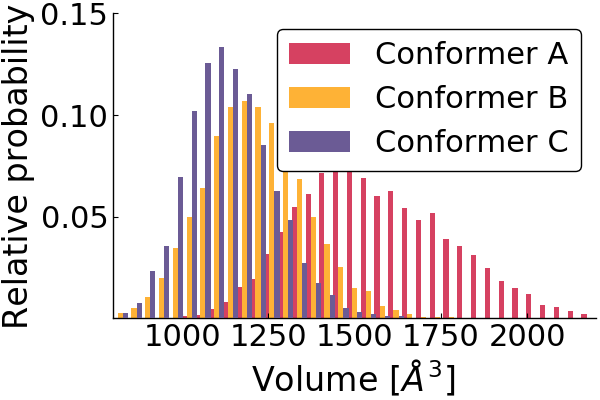

In [32]:
st = 40
bw = 28
fa = .9
bin_range = 800:st:2200
bin_vol = collect(bin_range)

# Histograma ponderado
wgh_vol = fill(1.0, length(idx_vol1))
bin_vol1_4xcp, his_vol1_4xcp = JUMD.weightedHist(trj_vol1, bin_vol, wgh_vol, true, false)

wgh_vol = fill(1.0, length(idx_vol2))
bin_vol2_4xcp, his_vol2_4xcp = JUMD.weightedHist(trj_vol2, bin_vol, wgh_vol, true, false)

wgh_vol = fill(1.0, length(idx_vol3))
bin_vol3_4xcp, his_vol3_4xcp = JUMD.weightedHist(trj_vol3, bin_vol, wgh_vol, true, false)

grp = repeat(["Conformer A", "Conformer B", "Conformer C"], inner = length(bin_vol1_4xcp))
clr = repeat([colorant"#d64161", colorant"#feb236", colorant"#6b5b95"],
    inner = length(bin_vol1_4xcp))

plt_his_vols = groupedbar(
    repeat(bin_vol1_4xcp, outer = 3), hcat(his_vol1_4xcp, his_vol2_4xcp, his_vol3_4xcp),
    group = grp, fillcolor = clr, bar_width = 45,
    xticks = 1E3:250:2E3, yticks = .05:.05:.2,
    xlims = (800, 2200), 
#      xlims = (800, 3200), 
    ylims = (0, .15),
    
    linecolor = false, grid = false,
     legend =:topright,
#     legend = false,
    guidefont = font(24, "Arial"), tickfont = font(22, "Arial"), legendfont = font(22, "Arial"),
    yaxis = "Relative probability", xaxis = L"Volume $[\AA^3]$ ")

In [9]:
savefig(plt_his_vols, joinpath(rtdos, "papel", "4", string("4_VolHis_", pdb, ".svg")))
# savefig(plt_his_vols, joinpath(rtdos, "papel", "4", string("4_legend_", pdb, ".svg")))

In [33]:
hcat([ mean(trj_vol1) ; mean(trj_vol2) ; mean(trj_vol3) ],
    [ std(trj_vol1) ; std(trj_vol2) ; std(trj_vol3) ])

3×2 Array{Float64,2}:
 1567.64  222.059
 1211.21  150.376
 1130.05  125.841

In [10]:
trj_vol1_smooth = [ mean(trj_vol1[i:i+10]) for i = 1:10:length(trj_vol1)-10 ]
trj_vol2_smooth = [ mean(trj_vol2[i:i+10]) for i = 1:10:length(trj_vol2)-10 ]
trj_vol3_smooth = [ mean(trj_vol3[i:i+10]) for i = 1:10:length(trj_vol3)-10 ]

idx_vol1_smooth = [ idx_vol1[i] for i = 1:10:length(idx_vol1)-10 ]
idx_vol2_smooth = [ idx_vol2[i] for i = 1:10:length(idx_vol2)-10 ]
idx_vol3_smooth = [ idx_vol3[i] for i = 1:10:length(idx_vol3)-10 ];

grupos = [ fill("Conformer A", length(idx_vol1_smooth));
    fill("Conformer B", length(idx_vol2_smooth)); 
    fill("Conformer C", length(idx_vol3_smooth)) ];

In [26]:
ma = .9
plt_vol_pop = scatter(idx_vol1_smooth, trj_vol1_smooth,  label = "Conformer A",
    markersize = 2., markeralpha = ma, markerstrokewidth = .1, seriescolor = colorant"#d64161",
    xticks = (1E5:1E5:3E5, ["1", "2", "3"]),
    grid = false, legend = false,
    guidefont = font(24, "Arial"), tickfont = font(22, "Arial"), legendfont = font(22, "Arial"),
    yaxis = L"Volume $[\AA^{3}]$", xaxis = "Time [μs]")

scatter!(idx_vol2_smooth, trj_vol2_smooth, label = "Conformer B",
    markersize = 2., markeralpha = ma, markerstrokewidth = .1, seriescolor = colorant"#feb236")

scatter!(idx_vol3_smooth, trj_vol3_smooth, label = "Conformer C",
    markersize = 2., markeralpha = ma, markerstrokewidth = .1, seriescolor = colorant"#6b5b95");

In [27]:
savefig(plt_vol_pop, joinpath(rtdos, "papel", "4", string("4_Vol_", pdb, ".svg")))

## Métodos de Marcos

In [ ]:
dif = h5read(joinpath(rtdos, string("diff_", pdb, ".h5")), "dif")
norm_dif = mapslices(x -> x ./ norm(x), dif,  dims = 1)
nframes = size(dif)[2]

prj_1_4xcp = Array{Float64, 1}(undef, nframes)
prj_2_4xcp = Array{Float64, 1}(undef, nframes)
prj_3_4xcp = Array{Float64, 1}(undef, nframes)

for i = 1:nframes
    prj_1_4xcp[i] = dot(norm_dif[:, i], modes_4xcp[:, 1])
    prj_2_4xcp[i] = dot(norm_dif[:, i], modes_4xcp[:, 2])
    prj_3_4xcp[i] = dot(norm_dif[:, i], modes_4xcp[:, 3])
end

# Smooth
smooth_prj_1_4xcp = [ mean(prj_1_4xcp[i:i+9]) for i = 1:10:length(prj_1_4xcp)-9 ]
smooth_prj_2_4xcp = [ mean(prj_2_4xcp[i:i+9]) for i = 1:10:length(prj_2_4xcp)-9 ]
smooth_prj_3_4xcp = [ mean(prj_3_4xcp[i:i+9]) for i = 1:10:length(prj_3_4xcp)-9 ];

In [ ]:
### 1
nframes_vol1 = length(idx_vol1)
        
marcos_pnu_vol1 = h5read(joinpath(rtdos, string("marcos_pnu_vol1_", pdb, ".h5")), "pnu")

# Read Frecuencia de apariciónd de c/ modo en los subespacios de pnumber modos
marcos_modos_vol1 = Array{Array{Int64, 1}}(undef, nframes_vol1)
fid = h5open(joinpath(rtdos, string("marcos_modos_vol1_", pdb, ".h5")), "r")
for i = 1:nframes_vol1
    marcos_modos_vol1[i] = read(fid, string("frame_", i)) 
end
close(fid)

flat_marcos_modos_vol1 = collect(Iterators.flatten(marcos_modos_vol1))

### 2
nframes_vol2 = length(idx_vol2)
        
marcos_pnu_vol2 = h5read(joinpath(rtdos, string("marcos_pnu_vol2_", pdb, ".h5")), "pnu")

# Read Frecuencia de apariciónd de c/ modo en los subespacios de pnumber modos
marcos_modos_vol2 = Array{Array{Int64, 1}}(undef, nframes_vol2)
fid = h5open(joinpath(rtdos, string("marcos_modos_vol2_", pdb, ".h5")), "r")
for i = 1:nframes_vol2
    marcos_modos_vol2[i] = read(fid, string("frame_", i)) 
end
close(fid)

flat_marcos_modos_vol2 = collect(Iterators.flatten(marcos_modos_vol2))

### 3
nframes_vol3 = length(idx_vol3)
        
marcos_pnu_vol3 = h5read(joinpath(rtdos, string("marcos_pnu_vol3_", pdb, ".h5")), "pnu")

# Read Frecuencia de apariciónd de c/ modo en los subespacios de pnumber modos
marcos_modos_vol3 = Array{Array{Int64, 1}}(undef, nframes_vol3)
fid = h5open(joinpath(rtdos, string("marcos_modos_vol3_", pdb, ".h5")), "r")
for i = 1:nframes_vol3
    marcos_modos_vol3[i] = read(fid, string("frame_", i)) 
end
close(fid)

flat_marcos_modos_vol3 = collect(Iterators.flatten(marcos_modos_vol3));

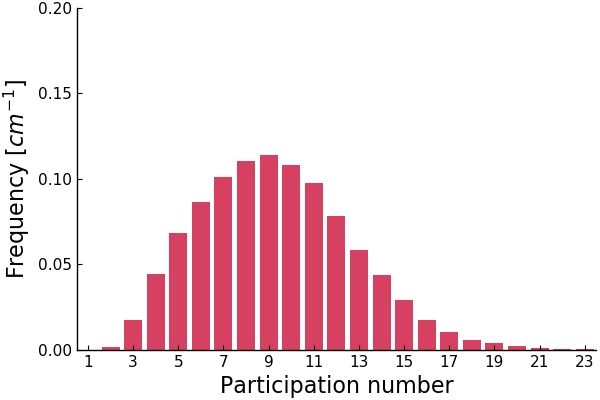

In [28]:
bin_pnu = collect(1:1:25)
wgh_pnu = fill(1.0, length(marcos_pnu_vol1))

# Histograma ponderado
bins_marcos_pnu_vol1, his_marcos_pnu_vol1 = JUMD.WeightedHist(
    marcos_pnu_vol1, bin_pnu, wgh_pnu, true, false);

plt_his_pn_vol1 = bar(bins_marcos_pnu_vol1 .- .5, his_marcos_pnu_vol1,
    ylims = (0, .2), xlims = (.5, 23.5),
    xticks = 1:2:23, yticks = 0:.05:.2,
    guidefont = font(16, "Helvetica"), tickfont = font(11, "Helvetica"),
    fillcolor = Colors.colorant"#d64161", linecolor = false,
    guidefont = font(16, "Arial"), tickfont = font(11, "Arial"),
    yaxis = "Density", xaxis = "Participation number", legend = false)

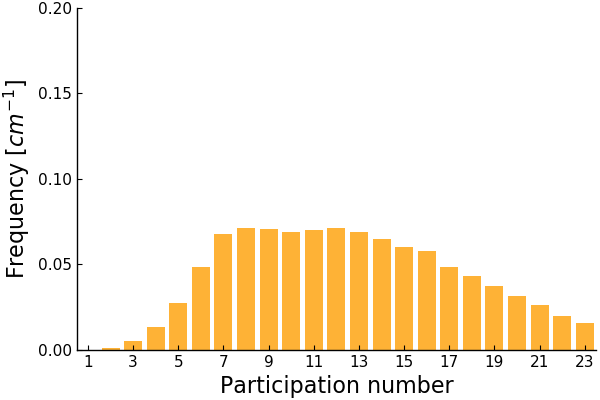

In [29]:
bin_pnu = collect(1:1:25)
wgh_pnu = fill(1.0, length(marcos_pnu_vol2))

# Histograma ponderado
bins_marcos_pnu_vol2, his_marcos_pnu_vol2 = JUMD.WeightedHist(
    marcos_pnu_vol2, bin_pnu, wgh_pnu, true, false);

plt_his_pn_vol2 = bar(bins_marcos_pnu_vol2 .- .5, his_marcos_pnu_vol2,
    ylims = (0, .2), xlims = (.5, 23.5),
    xticks = 1:2:23, yticks = 0:.05:.2,
    guidefont = font(16, "Helvetica"), tickfont = font(11, "Helvetica"),
    fillcolor = Colors.colorant"#feb236", linecolor = false,
    guidefont = font(16, "Arial"), tickfont = font(11, "Arial"),
    yaxis = "Density", xaxis = "Participation number", legend = false)

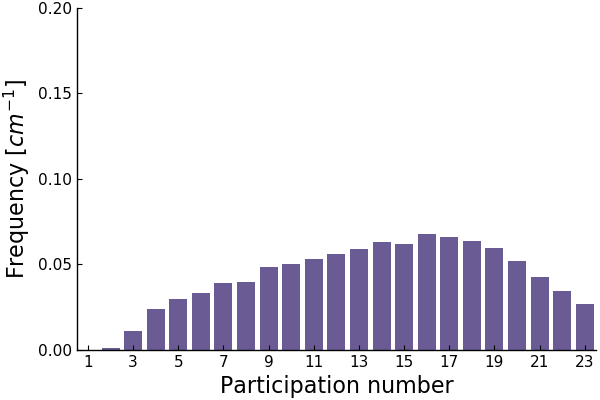

In [30]:
bin_pnu = collect(1:1:25)
wgh_pnu = fill(1.0, length(marcos_pnu_vol3))

# Histograma ponderado
bins_marcos_pnu_vol3, his_marcos_pnu_vol3 = JUMD.WeightedHist(
    marcos_pnu_vol3, bin_pnu, wgh_pnu, true, false);

plt_his_pn_vol3 = bar(bins_marcos_pnu_vol3 .- .5, his_marcos_pnu_vol3,
    ylims = (0, .2), xlims = (.5, 23.5),
    xticks = 1:2:23, yticks = 0:.05:.2,
    guidefont = font(16, "Helvetica"), tickfont = font(11, "Helvetica"),
    fillcolor = Colors.colorant"#6b5b95", linecolor = false,
    guidefont = font(16, "Arial"), tickfont = font(11, "Arial"),
    yaxis = "Density", xaxis = "Participation number", legend = false)

## 3 poblaciones + corrida entera

In [32]:
using AverageShiftedHistograms

In [33]:
# Read Pnumbers
marcos_pnu = h5read(joinpath(rtdos, string("marcos_pnu_", pdb, ".h5")), "pnu")

st = 1
bw = 28
fa = .7
bin_range = 1:st:25
bin_pnu = collect(bin_range)
wgh_pnu = fill(1.0, length(marcos_pnu))
m_ = 2

# Histograma ponderado
bins_marcos_pnu, his_marcos_pnu = JUMD.WeightedHist(marcos_pnu, bin_pnu, wgh_pnu, true, false);

# Suavizado
ash_pnu_vol1 = ash(marcos_pnu_vol1, rng = bin_range, m = m_,
    kernel = AverageShiftedHistograms.Kernels.gaussian)
xy_pnu_vol1 = xy(ash_pnu_vol1);

ash_pnu_vol2 = ash(marcos_pnu_vol2, rng = bin_range, m = m_,
    kernel = AverageShiftedHistograms.Kernels.gaussian)
xy_pnu_vol2 = xy(ash_pnu_vol2);

ash_pnu_vol3 = ash(marcos_pnu_vol3, rng = bin_range, m = m_,
    kernel = AverageShiftedHistograms.Kernels.gaussian)
xy_pnu_vol3 = xy(ash_pnu_vol3);

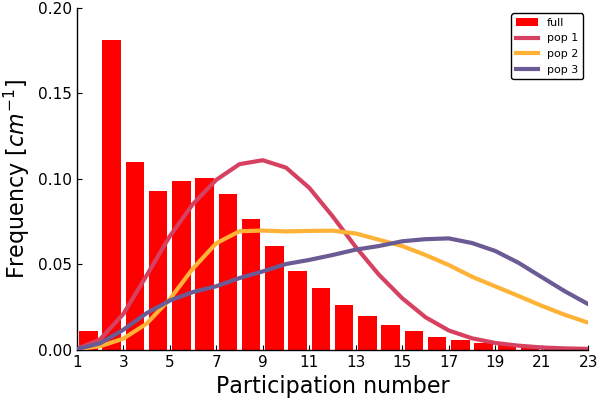

In [34]:
plt_his_pnus = bar(bins_marcos_pnu, his_marcos_pnu,
    label = "full",
    
    xticks = 1:2:23,
    xlims = (1, 23), ylims = (0, .2),
    fillcolor = Colors.colorant"#FF0000", linecolor = false,
    grid = false,  legend = (.9, .95),
    guidefont = font(16, "Arial"), tickfont = font(11, "Arial"),
    yaxis = "Density", xaxis = "Participation number")

plot!(xy_pnu_vol1, linecolor = colorant"#d64161", label = "pop 1", linewidth = 3)
plot!(xy_pnu_vol2, linecolor = colorant"#feb236", label = "pop 2", linewidth = 3)
plot!(xy_pnu_vol3, linecolor = colorant"#6b5b95", label = "pop 3", linewidth = 3)

In [35]:
savefig(plt_his_pnus, joinpath(rtdos, "papel", "2",
        string("2_HisPn_", pdb, ".svg")))

### RMSD de lig en poblaciones prot. Guardo el frame más similar al avg

rmsd_vol1 = convert(Array{Float64, 1}, readdlm(joinpath(
            home, pdb, "poblaciones", "intra", string("rmsd_vol1")))[2:end, 2])
rmsd_vol2 = convert(Array{Float64, 1}, readdlm(joinpath(
                home, pdb, "poblaciones", "intra", string("rmsd_vol2")))[2:end, 2])
rmsd_vol3 = convert(Array{Float64, 1}, readdlm(joinpath(
                    home, pdb, "poblaciones", "intra", string("rmsd_vol3")))[2:end, 2]);

### Volume 1
trj_in = Trajectory(joinpath(home, pdb, "poblaciones", string("vol1_", pdb, ".nc")))
in_top_trj = Trajectory(joinpath(home, pdb, "poblaciones", "intra", string("avg_vol1_", pdb, ".pdb")))
in_top_frm = read(in_top_trj)
in_top = Topology(in_top_frm)
in_frm = read_step(trj_in, argmin(rmsd_vol1) - 1)
set_topology!(in_frm, in_top)
trj_out = Trajectory(joinpath(home, pdb, "poblaciones", "intra", string("top_vol1_", pdb, ".pdb")), 'w')
write(trj_out, in_frm)
close(trj_out)
close(trj_in)

### Volume 2
trj_in = Trajectory(joinpath(home, pdb, "poblaciones", string("vol2_", pdb, ".nc")))
in_top_trj = Trajectory(joinpath(home, pdb, "poblaciones", "intra", string("avg_vol2_", pdb, ".pdb")))
in_top_frm = read(in_top_trj)
in_top = Topology(in_top_frm)
in_frm = read_step(trj_in, argmin(rmsd_vol2) - 1)
set_topology!(in_frm, in_top)
trj_out = Trajectory(joinpath(home, pdb, "poblaciones", "intra", string("top_vol2_", pdb, ".pdb")), 'w')
write(trj_out, in_frm)
close(trj_out)
close(trj_in)

### Volume 3
trj_in = Trajectory(joinpath(home, pdb, "poblaciones", string("vol3_", pdb, ".nc")))
in_top_trj = Trajectory(joinpath(home, pdb, "poblaciones", "intra", string("avg_vol3_", pdb, ".pdb")))
in_top_frm = read(in_top_trj)
in_top = Topology(in_top_frm)
in_frm = read_step(trj_in, argmin(rmsd_vol3) - 1)
set_topology!(in_frm, in_top)
trj_out = Trajectory(joinpath(home, pdb, "poblaciones", "intra", string("top_vol3_", pdb, ".pdb")), 'w')
write(trj_out, in_frm)
close(trj_out)
close(trj_in)

# Separo poblaciones